# BERTopic Data Exploration

This notebook performs the following tasks:

1. **Load** a previously cleaned or chunked dataset intended for BERTopic (from `bertopic_ready_data.json`).  
2. **Extract** documents (posts and comments).  
3. **Analyse** length distributions, high-frequency tokens, bigrams, and vocabulary growth.  
4. **Generate** plots (including a word cloud), saving them to a dedicated output folder.

This exploratory data analysis (EDA) provides insight into the text’s size, typical tokens, and potential bigrams before running BERTopic.

In [40]:
# ----------------------------------------------------------------------------------------
# 1) Imports and Setup
# ----------------------------------------------------------------------------------------
import json
import os
import statistics
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from wordcloud import WordCloud
import pandas as pd
from IPython.display import display

## 2) Helper Functins

These functions facilitate:
- **Loading** the BERTopic data (`load_bertopic_data`, `extract_bertopic_docs`),
- **Visualising** length distributions, top tokens, word clouds, bigrams,
- **Measuring** vocabulary growth curves over tokens in a sequence of documents.

In [41]:
def load_bertopic_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def extract_bertopic_docs(data):
    """
    Gathers 'combined_processed' from each post plus each comment's 'comment_processed'
    into a single list of docs.
    """
    all_docs = []
    for post in data:
        main_text = post.get('combined_processed', '').strip()
        if main_text:
            all_docs.append(main_text)

        comments = post.get('comments', [])
        for c in comments:
            c_text = c.get('comment_processed', '').strip()
            if c_text:
                all_docs.append(c_text)
    return all_docs

def extract_raw_docs(data):
    """
    Extracts raw text from posts and comments before processing.
    """
    all_docs = []
    for post in data:
        # Get post title and body
        title = post.get('title', '').strip()
        body = post.get('selftext', '').strip()
        if title or body:
            all_docs.append(f"{title} {body}".strip())
        
        # Get comments from post
        comments = post.get('comments', [])
        for comment in comments:
            raw_comment_text = comment.get('comment', '').strip()
            if raw_comment_text:
                all_docs.append(raw_comment_text)
    return all_docs

def visualize_length_distribution(lengths_list, labels, title, ax=None):
    """
    Compare length distributions of multiple datasets side by side on the given Axes object,
    or the current Axes if none is provided.
    """
    if ax is None:
        ax = plt.gca()

    colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange']
    for lengths, label, color in zip(lengths_list, labels, colors):
        ax.hist(lengths, bins=50, alpha=0.6, label=label, color=color, edgecolor='black')
    
    ax.set_title(title)
    ax.set_xlabel('Tokens per Document')
    ax.set_ylabel('Frequency')
    ax.legend()

def plot_top_tokens(counters_list, labels, title, top_n=20, ax=None):
    """
    Compare top tokens from multiple datasets side by side on the given Axes (or current).
    """
    if ax is None:
        ax = plt.gca()
    n_datasets = len(counters_list)
    
    offset = 0
    bar_width = 0.4
    colors = ['orange', 'lightgreen', 'purple', 'blue']
    
    for idx, (counter, label) in enumerate(zip(counters_list, labels)):
        top = counter.most_common(top_n)
        if not top:
            print(f"No tokens to plot for {label}")
            continue
        tokens, freqs = zip(*top)
        x_positions = range(len(tokens))
        shifted_x = [x + offset for x in x_positions]
        
        ax.bar(shifted_x, freqs, bar_width, color=colors[idx], edgecolor='black', label=label)
        if idx == 0:
            ax.set_xticks([x + bar_width*(n_datasets-1)/2 for x in x_positions])
            ax.set_xticklabels(tokens, rotation=45, ha='right')
        
        offset += bar_width
    
    ax.set_title(title)
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Frequency')
    ax.legend()

def generate_wordcloud(token_counts, title, ax=None):
    """
    Generate a wordcloud for a single dataset on the given Axes (or current).
    """
    if not token_counts:
        print(f"No tokens to generate wordcloud for {title}")
        return

    freq_dict = dict(token_counts)
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(freq_dict)

    if ax is None:
        ax = plt.gca()
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

def plot_bigrams(bigrams_lists, plot_labels, title, ax=None):
    """
    Compare top bigrams from multiple datasets side by side on the given Axes.
    """
    if ax is None:
        ax = plt.gca()
    
    n_sets = len(bigrams_lists)
    colors = ['purple', 'lightgreen', 'orange', 'skyblue']
    
    offset = 0
    bar_width = 0.4
    
    for idx, (bigrams, label) in enumerate(zip(bigrams_lists, plot_labels)):
        if not bigrams:
            continue
        bigram_labels = []
        freqs = []
        for (w1, w2), freq in bigrams:
            bigram_labels.append(f"{w1}_{w2}")
            freqs.append(freq)
        
        x_positions = range(len(bigram_labels))
        shifted_x = [x + offset for x in x_positions]
        
        ax.bar(shifted_x, freqs, bar_width, color=colors[idx], edgecolor='black', label=label)
        
        if idx == 0:
            ax.set_xticks([x + bar_width*(n_sets-1)/2 for x in x_positions])
            ax.set_xticklabels(bigram_labels, rotation=45, ha='right')
        
        offset += bar_width
    
    ax.set_title(title)
    ax.set_xlabel('Bigrams')
    ax.set_ylabel('Frequency')
    ax.legend()

def vocabulary_growth_curve(docs_list, labels, title, ax=None):
    """
    Compare vocabulary growth curves for multiple datasets in a single axis (or current).
    """
    if ax is None:
        ax = plt.gca()
    
    colors = ['green', 'blue', 'red', 'orange']
    
    for docs, label, color in zip(docs_list, labels, colors):
        unique_words = set()
        x_vals, y_vals = [], []
        token_counter = 0
        
        for doc in docs:
            tokens = doc.split()
            for t in tokens:
                token_counter += 1
                unique_words.add(t)
                x_vals.append(token_counter)
                y_vals.append(len(unique_words))
        
        ax.plot(x_vals, y_vals, color=color, label=label)
    
    ax.set_title(title)
    ax.set_xlabel('Number of Tokens Seen')
    ax.set_ylabel('Vocabulary Size')
    ax.legend()

def bigram_analysis(tokenized_docs, title, top_n=20):
    """
    Analyse bigrams in a collection of tokenized documents.
    Returns list of top bigram tuples with their frequencies.
    """
    bigram_counts = Counter()
    for doc in tokenized_docs:
        # Create bigrams for each document
        bigrams = list(zip(doc[:-1], doc[1:]))
        # Count them
        bigram_counts.update(bigrams)
    
    top_bigrams = bigram_counts.most_common(top_n)
    
    if not top_bigrams:
        print(f"No bigrams found in {title}")
        return []
        
    print(f"\nTop {top_n} Bigrams - {title}:")
    for i, ((w1, w2), freq) in enumerate(top_bigrams, 1):
        print(f"{i}. ({w1}, {w2}) => {freq}")
    
    return top_bigrams

## 3) Main Analysis Pipeline

The main function below:
1. Loads the dataset (`bertopic_ready_data.json`).
2. Extracts processed text from posts and comments.
3. Computes statistics on document lengths and tokens, prints top tokens, counts bigrams.
4. Saves various visualisations (histograms, word cloud, bar charts) in a folder called `bertopic_eda_visuals`.

Number of raw documents: 6481
Number of tokenized raw documents: 6481
Number of BERTopic documents: 6479
Number of tokenized BERTopic documents: 6479

Document Length Statistics:


,Metric,Raw,BERTopic
0,Average,135.27,86.52
1,Median,91,79
2,Min,1,1
3,Max,1645,688


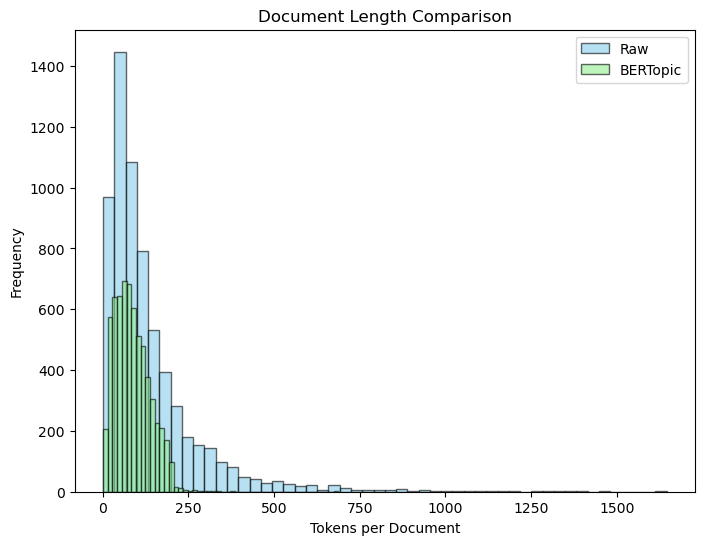

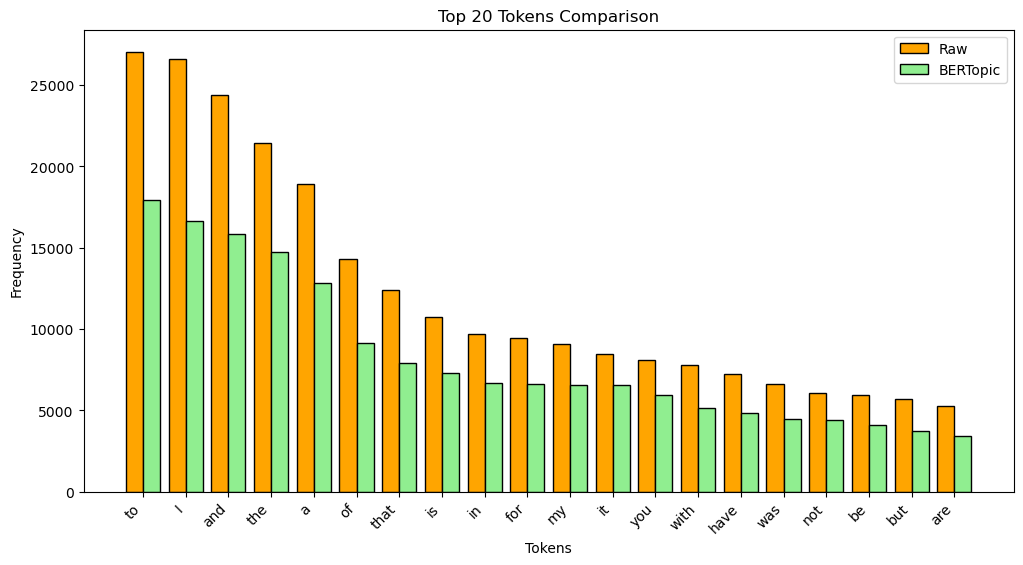

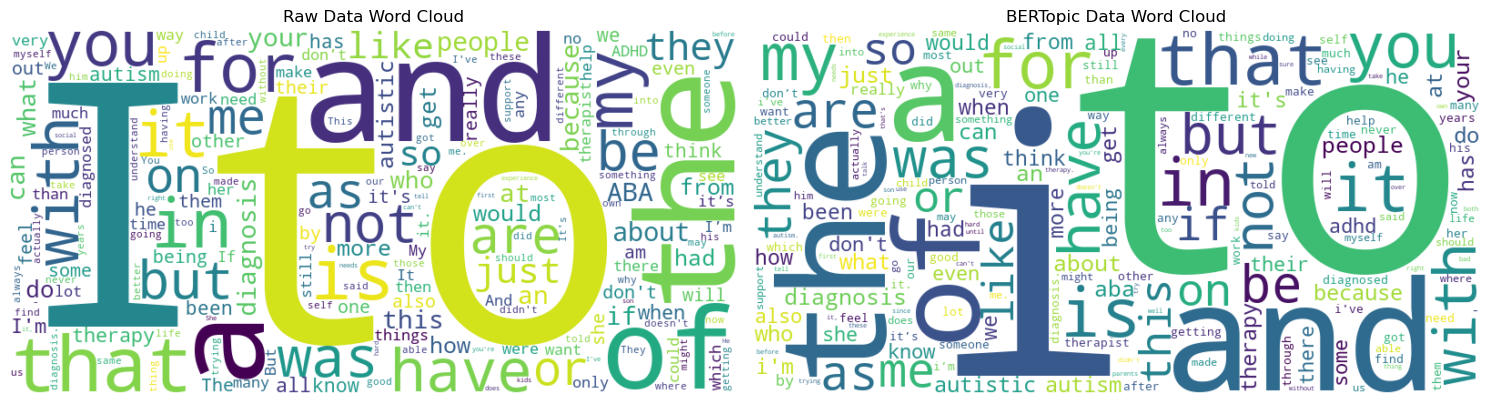


Top 20 Bigrams - Raw Data Bigrams:
1. (I, was) => 2382
2. (to, be) => 1964
3. (I, have) => 1743
4. (of, the) => 1658
5. (in, the) => 1626
6. (and, I) => 1464
7. (I, am) => 1397
8. (a, lot) => 1348
9. (that, I) => 1246
10. (to, get) => 1126
11. (lot, of) => 1088
12. (is, a) => 1000
13. (but, I) => 983
14. (want, to) => 961
15. (I, think) => 957
16. (have, a) => 908
17. (on, the) => 898
18. (in, a) => 891
19. (as, a) => 884
20. (I, had) => 870

Top 20 Bigrams - BERTopic Data Bigrams:
1. (i, was) => 1726
2. (i, have) => 1250
3. (to, be) => 1250
4. (in, the) => 1071
5. (of, the) => 1033
6. (and, i) => 1028
7. (a, lot) => 987
8. (i, am) => 931
9. (but, i) => 822
10. (to, get) => 773
11. (that, i) => 767
12. (lot, of) => 741
13. (i, think) => 719
14. (if, you) => 715
15. (is, a) => 672
16. (as, a) => 632
17. (it, was) => 623
18. (on, the) => 622
19. (have, a) => 600
20. (want, to) => 584


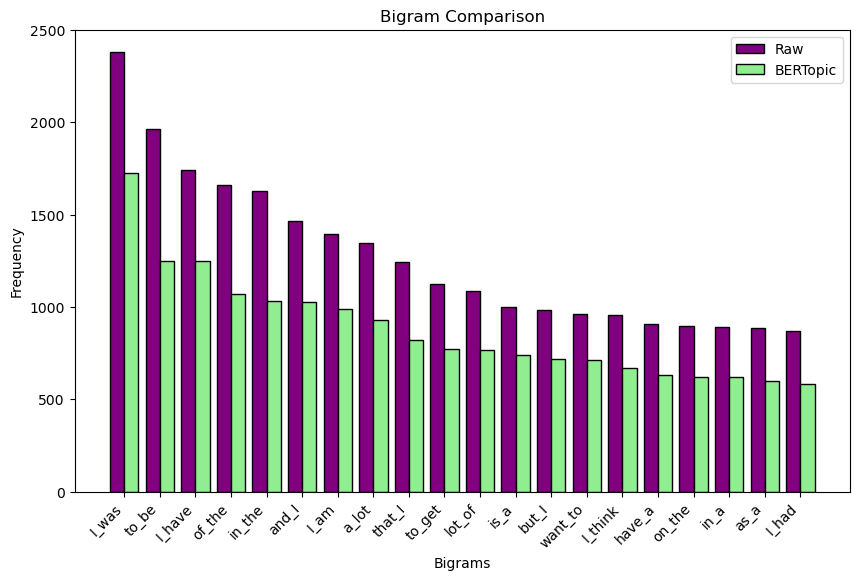

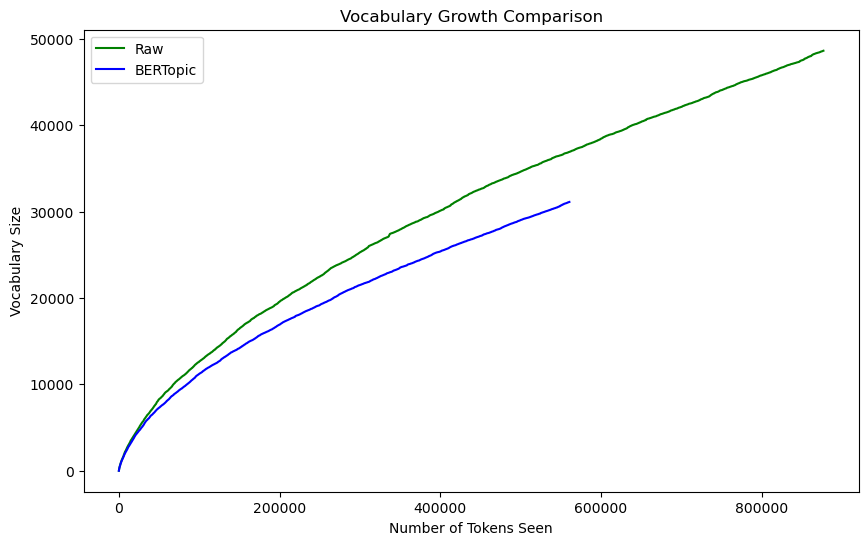

In [42]:
def main():
    """
    Main execution function that orchestrates the EDA process:
    1. Data Loading: Loads both raw and BERTopic-ready datasets
    2. Text Extraction: Extracts documents from both datasets
    3. Statistical Analysis: Computes document statistics
    4. Visualisation: Generates comparative visualisations
    5. Vocabulary Analysis: Analyses token distributions and patterns
    """
    # File paths configuration
    raw_path = Path(r"C:\Users\laure\Desktop\dissertation_notebook\Data\aggregated_raw_reddit_data.json")
    bertopic_path = Path(r"C:\Users\laure\Desktop\dissertation_notebook\Data\bertopic_ready_data.json")

    # Load and process data
    raw_data = load_bertopic_data(raw_path)
    bertopic_data = load_bertopic_data(bertopic_path)

    # Extract text documents using appropriate extractors
    raw_docs = extract_raw_docs(raw_data)
    bertopic_docs = extract_bertopic_docs(bertopic_data)

    # Tokenise each document
    raw_tokenized = [doc.split() for doc in raw_docs if doc.strip()]
    bertopic_tokenized = [doc.split() for doc in bertopic_docs if doc.strip()]

    # Document Length Statistics
    raw_lengths = [len(toks) for toks in raw_tokenized]
    bertopic_lengths = [len(toks) for toks in bertopic_tokenized]
    
    # Debug information
    print(f"Number of raw documents: {len(raw_docs)}")
    print(f"Number of tokenized raw documents: {len(raw_tokenized)}")
    print(f"Number of BERTopic documents: {len(bertopic_docs)}")
    print(f"Number of tokenized BERTopic documents: {len(bertopic_tokenized)}")
    
    if not raw_lengths or not bertopic_lengths:
        print("Warning: No valid documents found in one or both datasets")
        return
    
    stats_dict = {
        'Metric': ['Average', 'Median', 'Min', 'Max'],
        'Raw': [
            f"{statistics.mean(raw_lengths):.2f}", 
            statistics.median(raw_lengths),
            min(raw_lengths),
            max(raw_lengths)
        ],
        'BERTopic': [
            f"{statistics.mean(bertopic_lengths):.2f}",
            statistics.median(bertopic_lengths),
            min(bertopic_lengths),
            max(bertopic_lengths)
        ]
    }
    
    print("\nDocument Length Statistics:")
    display(pd.DataFrame(stats_dict))

    #Token Analysis
    raw_tokens = [t for doc in raw_tokenized for t in doc]
    bertopic_tokens = [t for doc in bertopic_tokenized for t in doc]
    
    raw_counts = Counter(raw_tokens)
    bertopic_counts = Counter(bertopic_tokens)

    # 1) Document length comparison in one figure
    plt.figure(figsize=(8, 6))
    visualize_length_distribution(
        [raw_lengths, bertopic_lengths],
        ["Raw", "BERTopic"],
        "Document Length Comparison"
    )
    plt.show()

    # 2) Top tokens side by side in one figure
    plt.figure(figsize=(12, 6))
    plot_top_tokens(
        [raw_counts, bertopic_counts],
        ["Raw", "BERTopic"],
        "Top 20 Tokens Comparison",
        top_n=20
    )
    plt.show()

    # 3) Generate side-by-side word clouds in a single figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Word Cloud for Raw data
    generate_wordcloud(raw_counts, "Raw Data", ax=ax1)
    ax1.set_title("Raw Data Word Cloud")

    # Word Cloud for BERTopic data
    generate_wordcloud(bertopic_counts, "BERTopic Data", ax=ax2)
    ax2.set_title("BERTopic Data Word Cloud")

    plt.tight_layout()
    plt.show()

    # 4) Bigram analysis
    raw_bigrams = bigram_analysis(raw_tokenized, "Raw Data Bigrams")
    bertopic_bigrams = bigram_analysis(bertopic_tokenized, "BERTopic Data Bigrams")

    # Plot bigrams in one figure
    plt.figure(figsize=(10, 6))
    plot_bigrams(
        [raw_bigrams, bertopic_bigrams],
        ["Raw", "BERTopic"],
        "Bigram Comparison"
    )
    plt.show()

    # 5) Vocabulary growth curves
    plt.figure(figsize=(10, 6))
    vocabulary_growth_curve(
        [raw_docs, bertopic_docs],
        ["Raw", "BERTopic"],
        "Vocabulary Growth Comparison"
    )
    plt.show()

if __name__ == "__main__":
    main()

## Conclusion

This notebook accomplishes the following:

- **Loads** the **BERTopic**-ready text data  
- Provides insights into **document lengths**, **token frequencies**, and **bigrams**  
- Produces multiple **visualisations** (histogram, bar charts, word cloud, and a vocabulary growth curve)

These exploratory analyses highlight patterns in the dataset and help guide future modelling steps or domain-specific stopword selection. The data is now ready for **BERTopic** or other advanced text analytics tools.

## References

**Reference:**  
Hunter, J. D. (2007) *Matplotlib: A 2D Graphics Environment* [computer program]. *Computing in Science & Engineering*, 9(3), pp. 90–95 (v3.7.3).  
Available from: [https://matplotlib.org/](https://matplotlib.org/) [Accessed 12 January 2025].

**Git Repo:**  
- [Matplotlib GitHub](https://github.com/matplotlib/matplotlib)

**Reference:**  
McKinney, W. (2010) *Data Structures for Statistical Computing in Python*. *Proceedings of the 9th Python in Science Conference*, pp. 51–56 (v2.2.3).  
Available from: [https://pandas.pydata.org/](https://pandas.pydata.org/) [Accessed 12 January 2025].

**Git Repo:**  
- [Pandas GitHub](https://github.com/pandas-dev/pandas)

**Reference:**  
Mueller, A. (2024) *Wordcloud: A Little Word Cloud Generator v1.9.2* [computer program].  
Available from: [https://github.com/amueller/word_cloud](https://github.com/amueller/word_cloud) [Accessed 12 January 2025].

**Git Repo:**  
- [WordCloud GitHub](https://github.com/amueller/word_cloud)